In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import sys, os, time, csv, glob, cv2

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

Using plaidml.keras.backend backend.


In [35]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/128x128/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/Users/ryan/NSL CNN/2d-cnn/128x128/train_attack/train_attack_equ_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/Users/ryan/NSL CNN/2d-cnn/128x128/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/Users/ryan/NSL CNN/2d-cnn/128x128/test_attack/test_attack_equ_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [36]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((469, 128, 128), (407, 128, 128), (68, 128, 128), (90, 128, 128))

In [50]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

## without rotate data
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal))                  

In [37]:
## if no augmented data is needed, run this cell
train = np.vstack((train_attack, train_normal))
test = np.vstack((test_attack, test_normal))

train.shape, test.shape

((876, 128, 128), (158, 128, 128))

In [51]:
train = train.reshape(-1,128,128,1)
test = test.reshape(-1,128,128,1)

train.shape, test.shape

((2628, 128, 128, 1), (474, 128, 128, 1))

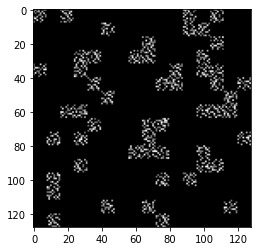

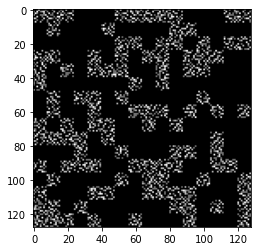

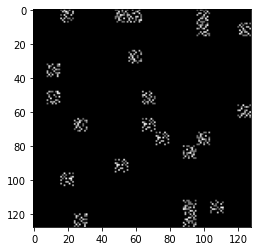

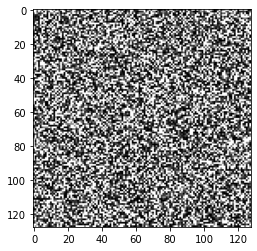

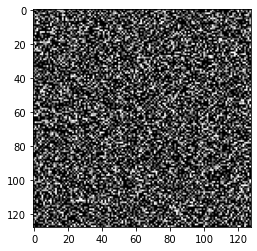

In [52]:
for i in range(0, 5):
    plt.imshow(train[i], cmap = 'gray')
    plt.show()

In [40]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [6]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [53]:
## create the training and testing data labels
## run this cell if using augmented data but not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [54]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(      attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 2623       0       1
 2624       0       1
 2625       0       1
 2626       0       1
 2627       0       1
 
 [2628 rows x 2 columns],
      attack  normal
 0         1       0
 1         1       0
 2         1       0
 3         1       0
 4         1       0
 ..      ...     ...
 469       0       1
 470       0       1
 471       0       1
 472       0       1
 473       0       1
 
 [474 rows x 2 columns])

In [55]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 0)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 0)

In [56]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [128,128,1]

cnn = Sequential()

## convolution 1
cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Conv2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

## convolution 6
# cnn.add(Conv2D(2**7, (2,2), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 16, 16, 128)       32896     
__________

In [57]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 300)
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
2628/2628 [==============================] - 12s 4ms/step - loss: 5.1019 - acc: 0.5472
Epoch 2/300
2628/2628 [==============================] - 4s 2ms/step - loss: 5.2542 - acc: 0.6178
Epoch 3/300
2628/2628 [==============================] - 4s 2ms/step - loss: 5.0043 - acc: 0.6338
Epoch 4/300
2628/2628 [==============================] - 4s 2ms/step - loss: 4.6418 - acc: 0.6410
Epoch 5/300
2628/2628 [==============================] - 4s 2ms/step - loss: 3.9854 - acc: 0.6459
Epoch 6/300
2628/2628 [==============================] - 4s 2ms/step - loss: 1.5813 - acc: 0.6062
Epoch 7/300
2628/2628 [==============================] - 4s 2ms/step - loss: 0.6871 - acc: 0.6290
Epoch 8/300
2628/2628 [==============================] - 4s 2ms/step - loss: 0.6262 - acc: 0.6526
Epoch 9/300
2628/2628 [==============================] - 4s 2ms/step - loss: 0.6091 - acc: 0.6714
Epoch 10/300
2628/2628 [==============================] - 4s 2ms/step - loss: 0.5923 - acc: 0.6743
Epoch 11/300
2628/

dict_keys(['loss', 'acc'])


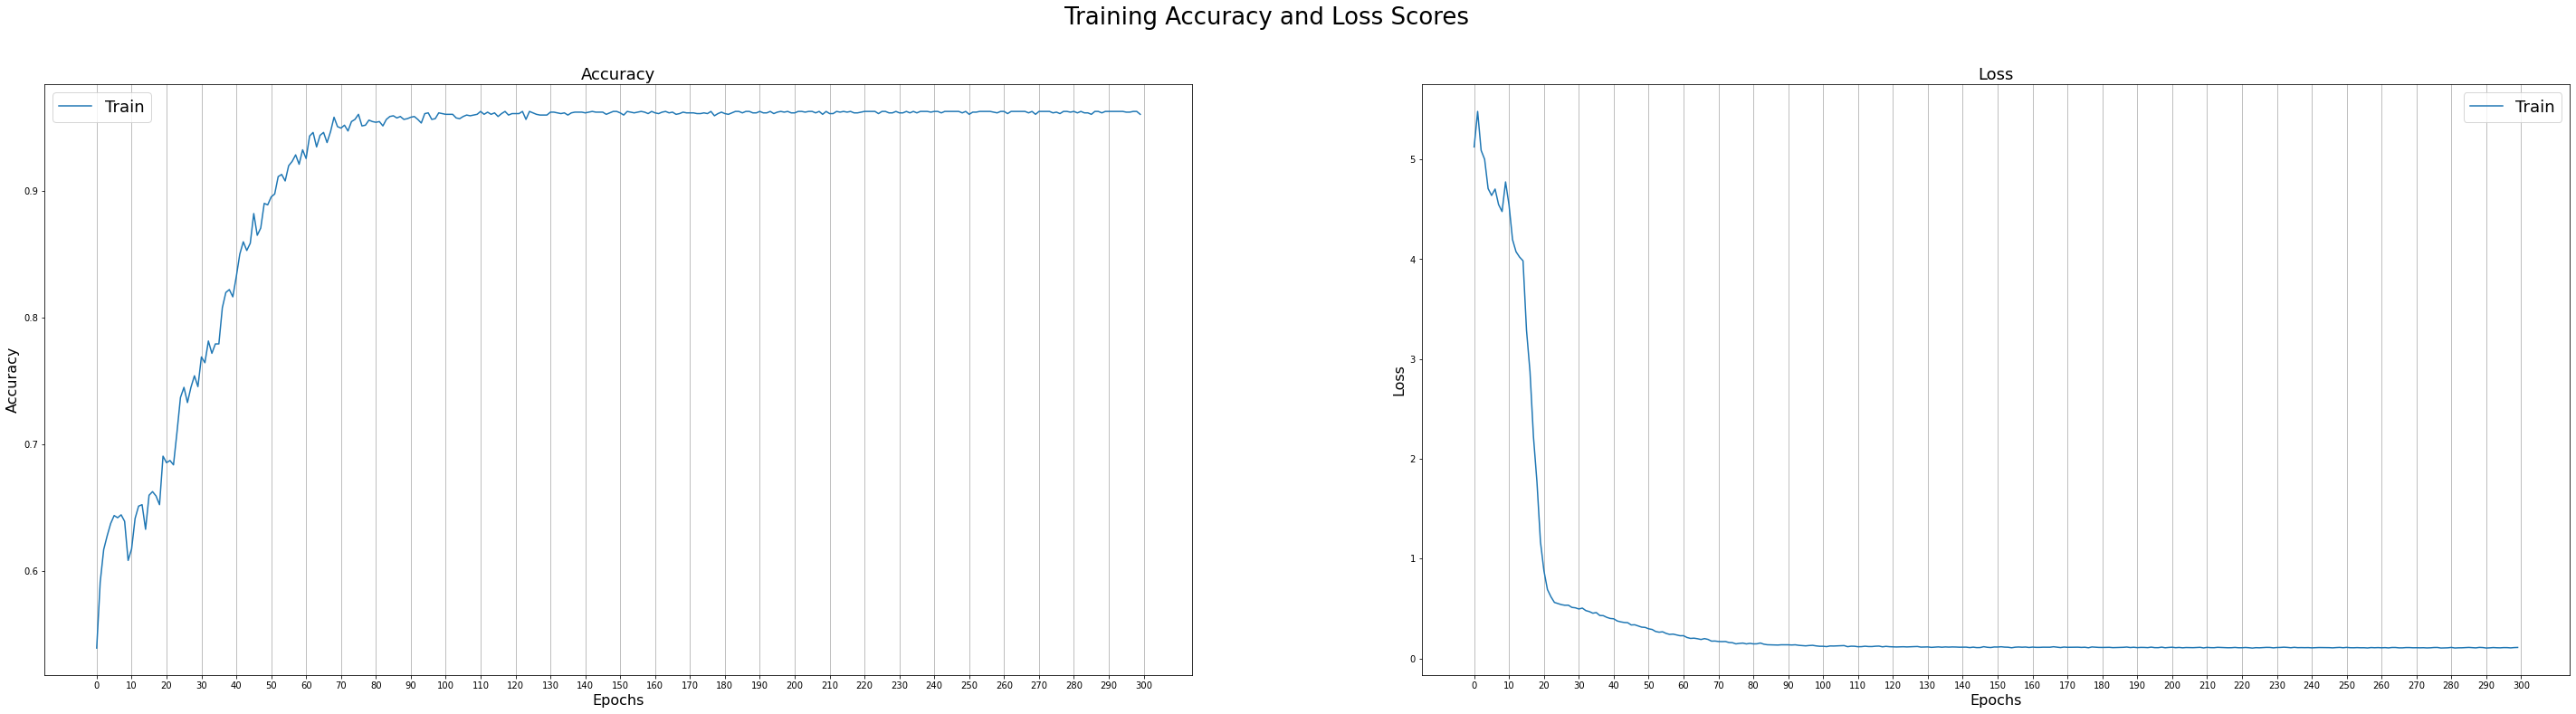

In [45]:
print(model_history.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 26)

axes[0].plot(model_history.history['acc'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [46]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 2.5494	Accuracy = 56.330000000000005%


In [47]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.96481, 0.03274],
       [0.9851 , 0.01356],
       [0.10462, 0.89273],
       [1.     , 0.     ],
       [0.00055, 0.99947],
       [0.9893 , 0.03235],
       [0.99385, 0.01261],
       [0.79344, 0.93663],
       [0.99987, 0.00165],
       [0.15681, 0.84277],
       [0.21272, 0.73353],
       [0.15681, 0.84277],
       [1.     , 0.     ],
       [0.00005, 0.99976],
       [0.99637, 0.00331],
       [0.84176, 0.13012],
       [0.15681, 0.84277],
       [0.02832, 0.99437],
       [1.     , 0.     ],
       [0.8139 , 0.29334]], dtype=float32)

In [48]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Conv2D(2**2, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Conv2D(2**3, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))
    
    ## convolution 4
#     cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
#     cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
#     cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 300)

In [49]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

os.system('say "cross validation finished"')

Epoch 1/300
126/126 [==============================] - 4s 29ms/step - loss: 5.8652 - acc: 0.4802
Epoch 2/300
126/126 [==============================] - 0s 552us/step - loss: 4.5198 - acc: 0.6190
Epoch 3/300
126/126 [==============================] - 0s 660us/step - loss: 4.6144 - acc: 0.6230
Epoch 4/300
126/126 [==============================] - 0s 536us/step - loss: 4.6409 - acc: 0.6468
Epoch 5/300
126/126 [==============================] - 0s 521us/step - loss: 4.8785 - acc: 0.6825
Epoch 6/300
126/126 [==============================] - 0s 516us/step - loss: 4.6531 - acc: 0.6944
Epoch 7/300
126/126 [==============================] - 0s 637us/step - loss: 4.4949 - acc: 0.7024
Epoch 8/300
126/126 [==============================] - 0s 494us/step - loss: 4.4518 - acc: 0.6984
Epoch 9/300
126/126 [==============================] - 0s 492us/step - loss: 4.6659 - acc: 0.6944
Epoch 10/300
126/126 [==============================] - 0s 494us/step - loss: 4.4981 - acc: 0.6944
Epoch 11/300
126/126

0

0